In [1]:
import cv2 as cv
from IPython.core.interactiveshell import InteractiveShell
from markdown import Markdown
from marker.config.parser import ConfigParser
from marker.converters.pdf import PdfConverter
from marker.models import create_model_dict
from marker.output import text_from_rendered
import numpy as np
import openai
import pandas as pd
from pydantic import BaseModel, Field
from rapidfuzz import fuzz
import tqdm
import matplotlib.pyplot as plt
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


import asyncio
import csv
import io
import json
import os
import re
import textwrap
from typing import List, Optional, Tuple, Union, Literal
import glob

In [2]:
# Configure Jupyter to display all output lines
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df_subset = pd.read_parquet(f"../data_temp/04 subset.parquet")
df_subset_filtered = df_subset[df_subset["is_in_questions"]==True]
pdf_name_i = df_subset_filtered["sha1"].iloc[0] + ".pdf"
output_path = f"../data_in/temp/md/{pdf_name_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text = f.read()

'../data_in/temp/md/0279901b645e568591ad95dac2c2bf939ef0c00d.pdf.md'

In [4]:
# Function to get text of a specific page
def get_page_text(text, page_number):
    """
    Extract text for a specified page number from the full document text.
    
    Args:
        text (str): The full document text
        page_number (int): The page number to extract
        
    Returns:
        str: The extracted text for the specified page
    """
    page_text = ""
    # Find the start and end of the page in the text
    page_marker = f"{{{page_number}}}------------------------------------------------"
    page_start = text.find(page_marker)
    if page_start != -1:
        page_start = page_start + len(page_marker)
        # Look for the next page marker or end of text
        next_page_marker = f"{{{page_number + 1}}}------------------------------------------------"
        next_page_start = text.find(next_page_marker, page_start)
        if next_page_start != -1:
            page_text = text[page_start:next_page_start]
        else:
            # If there's no next page, take all text until the end
            page_text = text[page_start:]
        return page_text
    else:
        return f"Page {page_number} is not found in the document."

# Example usage: Get text of page 91
page_91_text = get_page_text(text, 91)
print(page_91_text)



# **ACRES COMMERCIAL REALTY CORP. AND SUBSIDIARIES CONSOLIDATED BALANCE SHEETS (in thousands, except share and per share data)**

|                                                                                         |                 | December 31 |           |
|-----------------------------------------------------------------------------------------|-----------------|-------------|-----------|
|                                                                                         | 2022            |             | 2021      |
| (1)<br>ASSETS                                                                           |                 |             |           |
| Cash and cash equivalents                                                               | \$<br>66,232    | \$          | 35,500    |
| Restricted cash                                                                         | 38,579          |             | 248,431   |
| Accrued interest receivable                       

In [8]:
words_one_string = """assets
cash and cash equivalents
restricted cash
accrued interest receivable
cre loans
less: allowance for credit losses
cre loans, net
principal paydowns receivable
loan receivable - related party
investments in unconsolidated entities
properties held for sale
investments in real estate
right of use assets
intangible assets
other assets
total assets
liabilities
accounts payable and other liabilities
management fee payable - related party
accrued interest payable
borrowings
lease liabilities
distributions payable
accrued tax liability
liabilities held for sale
total liabilities
equity
preferred stock
common stock
additional paid-in capital
accumulated other comprehensive loss
distributions in excess of earnings
total stockholders' equity
non-controlling interests
total equity
total liabilities and equity"""
balance_sheet_words = words_one_string.split("\n")

In [52]:
words_one_string2 = """assets
current assets
cash and cash equivalents
restricted cash
royalty and milestone receivable
prepaid expenses
other current assets
total current assets
property and equipment
operating lease right-of-use asset
other assets
total assets
liabilities and stockholders' equity
current liabilities
accounts payable and other accrued liabilities
accrued compensation
liability related to the sale of royalties
short-term
current portion of long-term debt
other current liabilities
total current liabilities
liability related to the sale of royalties
long-term
long-term debt
operating lease liability
total liabilities
stockholders' equity
preferred stock
common stock
additional paid-in capital"""
balance_sheet_words2 = words_one_string2.split("\n")
balance_sheet_words3 = set(balance_sheet_words2) | set(balance_sheet_words)
print(f"len(balance_sheet_words): {len(balance_sheet_words)}")
print(f"len(balance_sheet_words2): {len(balance_sheet_words2)}")
print(f"len(balance_sheet_words3): {len(balance_sheet_words3)}")

len(balance_sheet_words): 36
len(balance_sheet_words2): 30
len(balance_sheet_words3): 56


In [65]:
words_one_string = """assets
current assets
cash and cash equivalents
trade receivables and contract assetsother financial assets
inventories
lease receivables
current tax assets
prepayments and other assets
assets held for sale
total current assets
non-current assets
trade receivables and contract assets
equity accounted investments
property, plant and equipment
right-of-use assets
intangible assets
other financial assets
deferred tax assets
prepayments and other assets
total non-current assets
total assets
liabilities
current liabilities
trade payables and contract liabilities
borrowings
lease liabilities
other financial liabilities
employee benefits provision
other provisions
current tax liabilities
liabilities held for sale
total current liabilities
non-current liabilities
trade payables and contract liabilities
borrowings
lease liabilities
other financial liabilities
employee benefits provision
other provisions
deferred tax liabilities
total non-current liabilities
total liabilities
net assets
equity
issued capital
reserves
retained earnings
parent interests
non-controlling interest
total equity"""
balance_sheet_words4 = words_one_string.split("\n")
balance_sheet_words5 = set(balance_sheet_words3) | set(balance_sheet_words4)
print(f"len(balance_sheet_words):  {len(balance_sheet_words)}")
print(f"len(balance_sheet_words2): {len(balance_sheet_words2)}")
print(f"len(balance_sheet_words3): {len(balance_sheet_words3)}")
print(f"len(balance_sheet_words4): {len(balance_sheet_words4)}")
print(f"len(balance_sheet_words5): {len(balance_sheet_words5)}")

len(balance_sheet_words):  36
len(balance_sheet_words2): 30
len(balance_sheet_words3): 56
len(balance_sheet_words4): 50
len(balance_sheet_words5): 84


In [89]:
words_one_string = """current assets
cash and cash equivalents
trade and other receivables
prepayments
total current assets
non-current assets
motor vehicles
plant and equipment
exploration and evaluation assets
total non-current assets
total assets
current liabilities
trade and other payables
provisions
total current liabilities
total liabilities
net assets
equity
issued capital
reserves
accumulated losses
total equity"""
balance_sheet_words_text4 = words_one_string.split("\n")
balance_sheet_words6 = set(balance_sheet_words5) | set(balance_sheet_words_text4)
print(f"len(balance_sheet_words):  {len(balance_sheet_words)}")
print(f"len(balance_sheet_words2): {len(balance_sheet_words2)}")
print(f"len(balance_sheet_words3): {len(balance_sheet_words3)}")
print(f"len(balance_sheet_words4): {len(balance_sheet_words4)}")
print(f"len(balance_sheet_words5): {len(balance_sheet_words5)}")
print(f"len(balance_sheet_words_text4): {len(balance_sheet_words_text4)}")
print(f"len(balance_sheet_words6): {len(balance_sheet_words6)}")

len(balance_sheet_words):  36
len(balance_sheet_words2): 30
len(balance_sheet_words3): 56
len(balance_sheet_words4): 50
len(balance_sheet_words5): 84
len(balance_sheet_words_text4): 22
len(balance_sheet_words6): 92


In [103]:
words_one_string = """assets
current assets
cash and cash equivalents
other receivables
inventories
derivative financial instruments
other current assets
income tax receivable
total current assets
non-current assets
plant and equipment
right-of-use assets
intangible assets
deferred tax assets
other non-current assets
total non-current assets
total assets
liabilities
current liabilities
trade and other payables
borrowings
provisions
derivative financial instruments
lease liabilities
other current liabilities
deferred consideration
contract liabilities
total current liabilities
non-current liabilities
borrowings
provisions
lease liabilities
other non-current liabilities
financial liabilities
deferred tax liabilities
total non-current liabilities
total liabilities
net assets
equity
issued capital
reserves
accumulated losses
total equity"""
balance_sheet_words_text5 = words_one_string.split("\n")
balance_sheet_words7 = set(balance_sheet_words6) | set(balance_sheet_words_text5)
print(f"len(balance_sheet_words):  {len(balance_sheet_words)}")
print(f"len(balance_sheet_words2): {len(balance_sheet_words2)}")
print(f"len(balance_sheet_words3): {len(balance_sheet_words3)}")
print(f"len(balance_sheet_words4): {len(balance_sheet_words4)}")
print(f"len(balance_sheet_words5): {len(balance_sheet_words5)}")
print(f"len(balance_sheet_words_text4): {len(balance_sheet_words_text4)}")
print(f"len(balance_sheet_words6): {len(balance_sheet_words6)}")
print(f"len(balance_sheet_words_text5): {len(balance_sheet_words_text5)}")
print(f"len(balance_sheet_words7): {len(balance_sheet_words7)}")

len(balance_sheet_words):  36
len(balance_sheet_words2): 30
len(balance_sheet_words3): 56
len(balance_sheet_words4): 50
len(balance_sheet_words5): 84
len(balance_sheet_words_text4): 22
len(balance_sheet_words6): 92
len(balance_sheet_words_text5): 43
len(balance_sheet_words7): 100


In [105]:
print("\n".join(balance_sheet_words7))

net assets
equity
liabilities held for sale
plant and equipment
preferred stock
accrued interest payable
current tax liabilities
current portion of long-term debt
principal paydowns receivable
assets
other current liabilities
total liabilities and equity
operating lease liability
accounts payable and other liabilities
non-controlling interest
exploration and evaluation assets
other non-current assets
liability related to the sale of royalties
total current liabilities
restricted cash
issued capital
less: allowance for credit losses
inventories
deferred tax liabilities
loan receivable - related party
contract liabilities
right of use assets
prepayments and other assets
retained earnings
liabilities and stockholders' equity
operating lease right-of-use asset
income tax receivable
other non-current liabilities
other assets
employee benefits provision
distributions in excess of earnings
deferred tax assets
cre loans, net
short-term
total equity
lease liabilities
properties held for sale
de

In [60]:
table_text = page_91_text
def extract_first_column_from_table(table_text):
    """
    Extracts the first column entries from a markdown table.
    
    Args:
        table_text (str): The text containing the markdown table
        
    Returns:
        list: A list of cleaned first column entries
    """
    # Split the table into lines
    lines = table_text.strip().splitlines()
    
    # List to store first column entries
    first_column = []
    
    # Process each line in the table
    for line in lines:
        # Check that the line starts with a pipe and is not just a separator line
        if line.startswith("|") and not re.match(r'^\|[-\s|]+$', line):
            # Split the line by the pipe symbol
            cells = line.split("|")
            # The first cell (after the initial empty element) is at index 1
            if len(cells) > 1:
                first_cell = cells[1].strip().replace("(1)","").replace("(2)","").replace("<br>","").lower()
                if first_cell == "":
                    continue
                first_column.append(first_cell)
    
    return first_column

# Extract the first column from the table
first_column = extract_first_column_from_table(table_text)

# Print the extracted first column values
print("Extracted First Column:")
for cell in first_column:
    print(cell)

Extracted First Column:
assets
cash and cash equivalents
restricted cash
accrued interest receivable
cre loans
less: allowance for credit losses
cre loans, net
principal paydowns receivable
loan receivable - related party
investments in unconsolidated entities
properties held for sale
investments in real estate
right of use assets
intangible assets
other assets
total assets
liabilities
accounts payable and other liabilities
management fee payable - related party
accrued interest payable
borrowings
lease liabilities
distributions payable
accrued tax liability
liabilities held for sale
total liabilities
equity
preferred stock, par value \$0.001: 10,000,000 shares authorized 8.625% fixed-to
floating series c cumulative redeemable preferred stock, liquidation preference \$25.00
per share; 4,800,000 and 4,800,000 shares issued and outstanding
preferred stock, par value \$0.001: 6,800,000 shares authorized 7.875% series d
cumulative redeemable preferred stock, liquidation preference \$25.00 

### Text 1

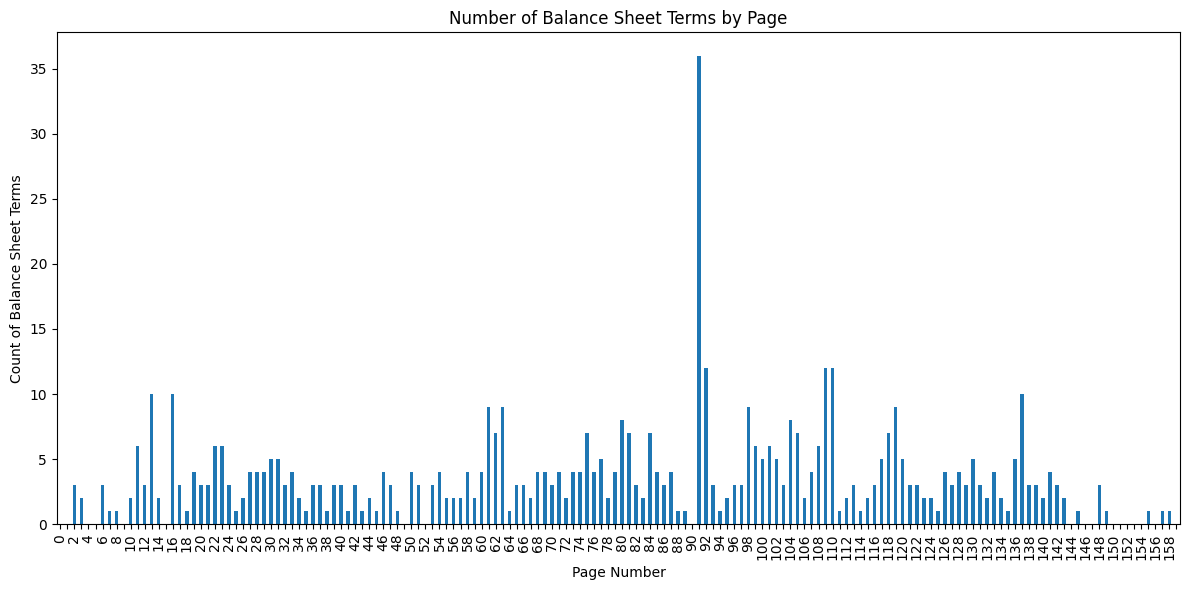

second_max: 12
max_count: 36
std_count: 3.6666094906920077
second_max: 12
snr:       9.818334919873246
snr_second: 3.0


In [47]:
def count_phrases_by_page(text, phrases):
    # Compile the regular expression for page markers.
    # The marker matches: "{" followed by one or more digits, then "}" and at least 48 hyphens.
    page_marker = re.compile(r"\{(\d+)\}-{48,}")

    # Split the text by the page markers.
    # With the capturing group, the list will include the page number(s) interleaved with the text parts.
    parts = page_marker.split(text)

    page_counts = {}

    # Optionally handle any text before the first page marker.
    if parts[0].strip():
        preface_text = parts[0]
        counts = {}
        for phrase in phrases:
            # Use re.escape to ensure the phrase is treated as literal text.
            pattern = re.compile(re.escape(phrase), flags=re.IGNORECASE)
            counts[phrase] = len(pattern.findall(preface_text))
        page_counts["preface"] = counts

    # Iterate over the list in pairs: page number and page text.
    for i in range(1, len(parts), 2):
        page_num = parts[i]
        page_text = parts[i+1] if (i+1) < len(parts) else ""
        counts = {}
        for phrase in phrases:
            pattern = re.compile(re.escape(phrase), flags=re.IGNORECASE)
            counts[phrase] = len(pattern.findall(page_text))
        page_counts[page_num] = counts

    return page_counts

res = count_phrases_by_page(text, balance_sheet_words)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second: {snr_second}")






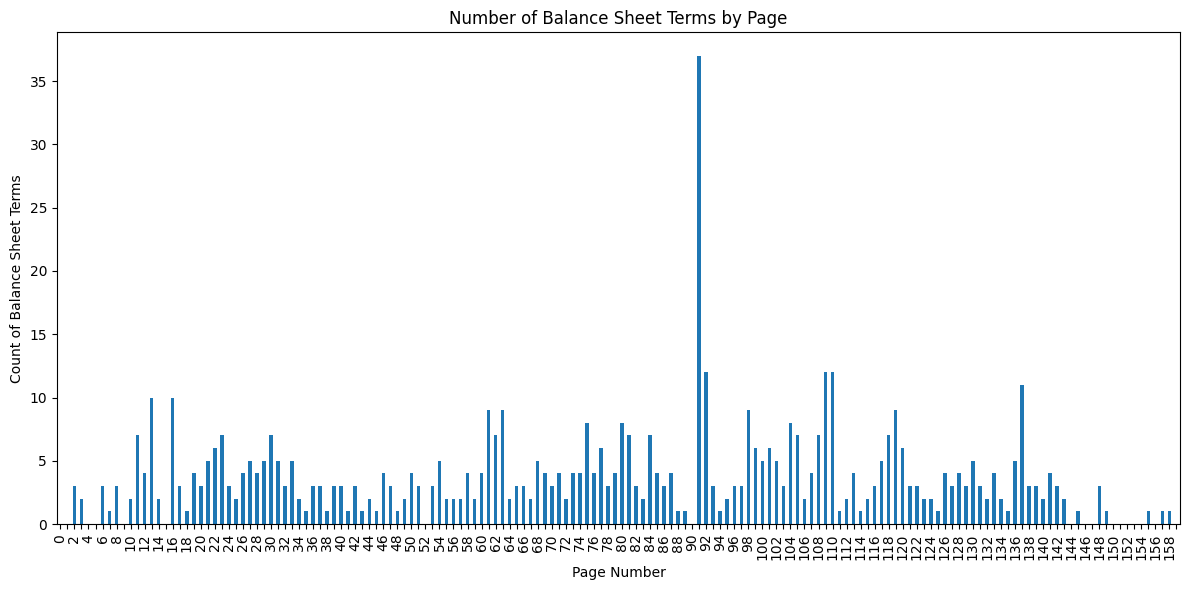

second_max: 12
max_count: 37
std_count: 3.7563363658066833
second_max: 12
snr:       9.85002310677099
snr_second: 3.0833333333333335


In [48]:
res = count_phrases_by_page(text, balance_sheet_words3)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second: {snr_second}")

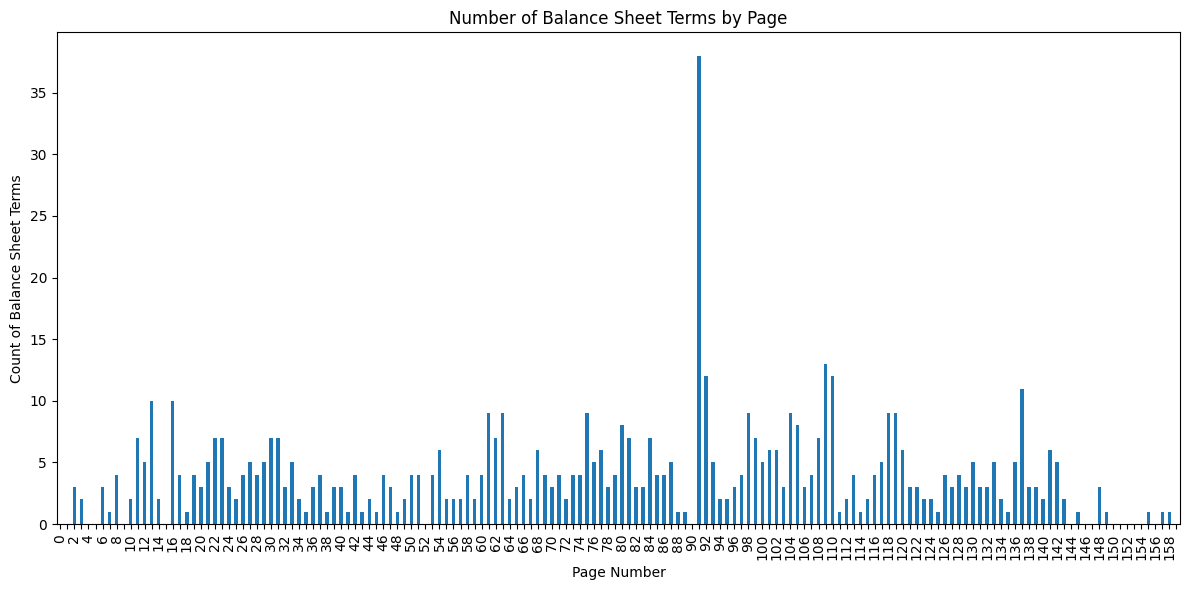

second_max: 13
max_count: 38
std_count: 3.8843137208213507
second_max: 13
snr:       9.782937921905232
snr_second: 2.923076923076923


In [67]:
res = count_phrases_by_page(text, balance_sheet_words5)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second: {snr_second}")

### Text 2

'../data_in/temp/EnterpriseRAG_2025_02_markdown/0981826b4b43a88920f3e01c71ae73539bab84cc/0981826b4b43a88920f3e01c71ae73539bab84cc.md'

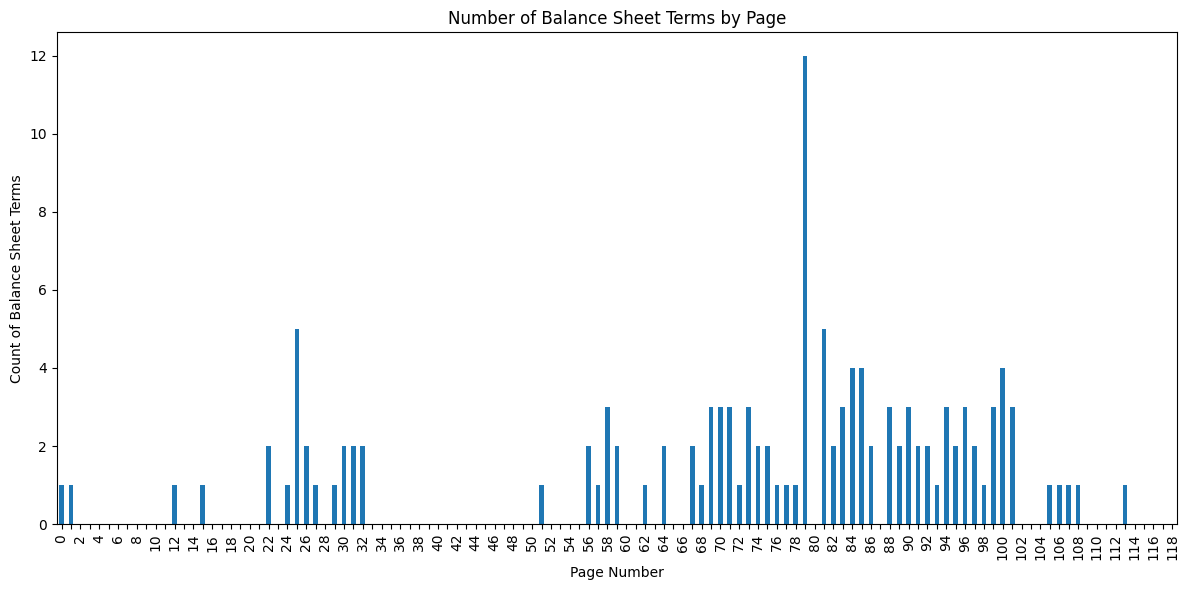

second_max: 5
max_count: 12
std_count: 1.6111879177165214
second_max: 5
snr:       7.447920796853522
snr_second:2.4


In [75]:
sha1_i = df_subset_filtered["sha1"].iloc[1]
pdf_name_i = sha1_i + ".pdf"
output_path = f"../data_in/temp/EnterpriseRAG_2025_02_markdown/{sha1_i}/{sha1_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text2 = f.read()

res = count_phrases_by_page(text2, balance_sheet_words)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")


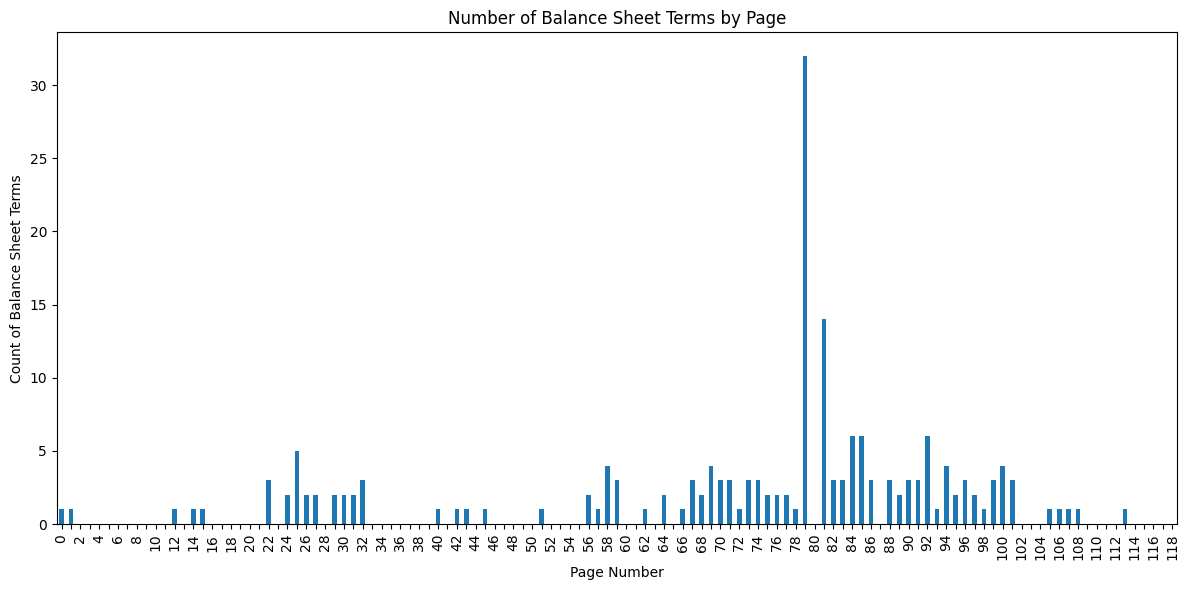

second_max: 14
max_count: 32
std_count: 3.3886545460596857
second_max: 14
snr:       9.443275956591526
snr_second:2.2857142857142856


In [76]:
res = count_phrases_by_page(text2, balance_sheet_words3)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

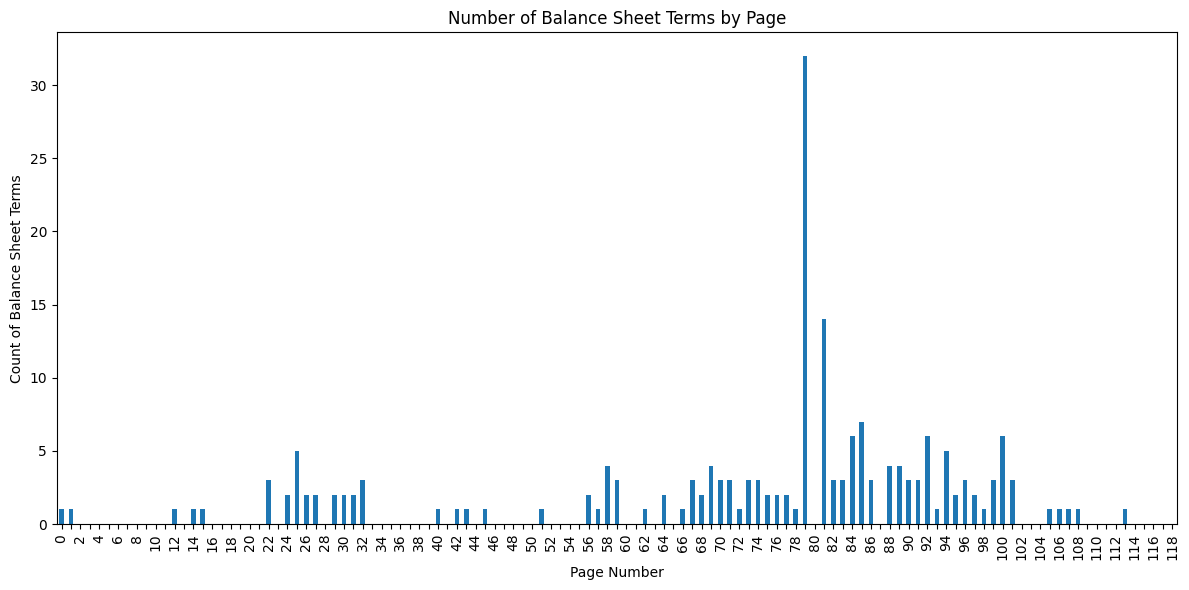

second_max: 14
max_count: 32
std_count: 3.436422786376611
second_max: 14
snr:       9.312009024867697
snr_second:2.2857142857142856


In [77]:
res = count_phrases_by_page(text2, balance_sheet_words5)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

In [24]:
bs_page = get_page_text(text2, 79)
print(bs_page)





### **Aptevo Therapeutics Inc. CONSOLIDATED BALANCE SHEETS (in thousands, except share and per share amounts)**

<span id="page-79-0"></span>

| ASSETS<br>Current assets:<br>Cash and cash equivalents<br>\$<br>22,635<br>\$<br>45,044<br>Restricted cash<br>—<br>1,259<br>Royalty and milestone receivable<br>2,500<br>3,664<br>Prepaid expenses<br>1,571<br>1,823<br>Other current assets<br>744<br>780<br>Total current assets<br>27,450<br>52,570<br>Property and equipment, net<br>1,462<br>2,379<br>Operating lease right-of-use asset<br>5,303<br>1,584<br>Other assets<br>—<br>68<br>Total assets<br>\$<br>34,215<br>\$<br>56,601<br>LIABILITIES AND STOCKHOLDERS' EQUITY<br>Current liabilities:<br>Accounts payable and other accrued liabilities<br>\$<br>3,499<br>\$<br>3,462<br>Accrued compensation<br>2,105<br>2,077<br>Liability related to the sale of royalties, net - short-term<br>—<br>15,465<br>Current portion of long-term debt<br>2,000<br>11,667<br>Other current liabilities<br>1,102<br>2,086<br>Total cu

In [36]:
temp_str = r"""ASSETS<br>Current assets:<br>Cash and cash equivalents<br>\$<br>22,635<br>\$<br>45,044<br>Restricted cash<br>—<br>1,259<br>Royalty and milestone receivable<br>2,500<br>3,664<br>Prepaid expenses<br>1,571<br>1,823<br>Other current assets<br>744<br>780<br>Total current assets<br>27,450<br>52,570<br>Property and equipment, net<br>1,462<br>2,379<br>Operating lease right-of-use asset<br>5,303<br>1,584<br>Other assets<br>—<br>68<br>Total assets<br>\$<br>34,215<br>\$<br>56,601<br>LIABILITIES AND STOCKHOLDERS' EQUITY<br>Current liabilities:<br>Accounts payable and other accrued liabilities<br>\$<br>3,499<br>\$<br>3,462<br>Accrued compensation<br>2,105<br>2,077<br>Liability related to the sale of royalties, net - short-term<br>—<br>15,465<br>Current portion of long-term debt<br>2,000<br>11,667<br>Other current liabilities<br>1,102<br>2,086<br>Total current liabilities<br>8,706<br>34,757<br>Liability related to the sale of royalties, net - long-term<br>—<br>15,580<br>Long-term debt<br>1,456<br>3,707<br>Operating lease liability<br>6,079<br>1,341<br>Total liabilities<br>16,241<br>55,385<br>Stockholders' equity:<br>Preferred stock: \$0.001 par value; 15,000,000 shares authorized, zero<br>shares issued or outstanding<br>—<br>—<br>Common stock: \$0.001 par value; 500,000,000 shares authorized;<br>6,466,294 and 4,898,143 shares issued and outstanding at December<br>31, 2022 and December 31, 2021, respectively<br>48<br>47<br>Additional paid-in capital"""
temp_str_lines = "\n".join([x.strip().lower() for x in temp_str.split("<br>")])
print(temp_str_lines)

assets
current assets:
cash and cash equivalents
\$
22,635
\$
45,044
restricted cash
—
1,259
royalty and milestone receivable
2,500
3,664
prepaid expenses
1,571
1,823
other current assets
744
780
total current assets
27,450
52,570
property and equipment, net
1,462
2,379
operating lease right-of-use asset
5,303
1,584
other assets
—
68
total assets
\$
34,215
\$
56,601
liabilities and stockholders' equity
current liabilities:
accounts payable and other accrued liabilities
\$
3,499
\$
3,462
accrued compensation
2,105
2,077
liability related to the sale of royalties, net - short-term
—
15,465
current portion of long-term debt
2,000
11,667
other current liabilities
1,102
2,086
total current liabilities
8,706
34,757
liability related to the sale of royalties, net - long-term
—
15,580
long-term debt
1,456
3,707
operating lease liability
6,079
1,341
total liabilities
16,241
55,385
stockholders' equity:
preferred stock: \$0.001 par value; 15,000,000 shares authorized, zero
shares issued or outst

### Text 3

'../data_in/temp/EnterpriseRAG_2025_02_markdown/0a61a353b1ea9fd9b8f63b60239634ca3007d58f/0a61a353b1ea9fd9b8f63b60239634ca3007d58f.md'

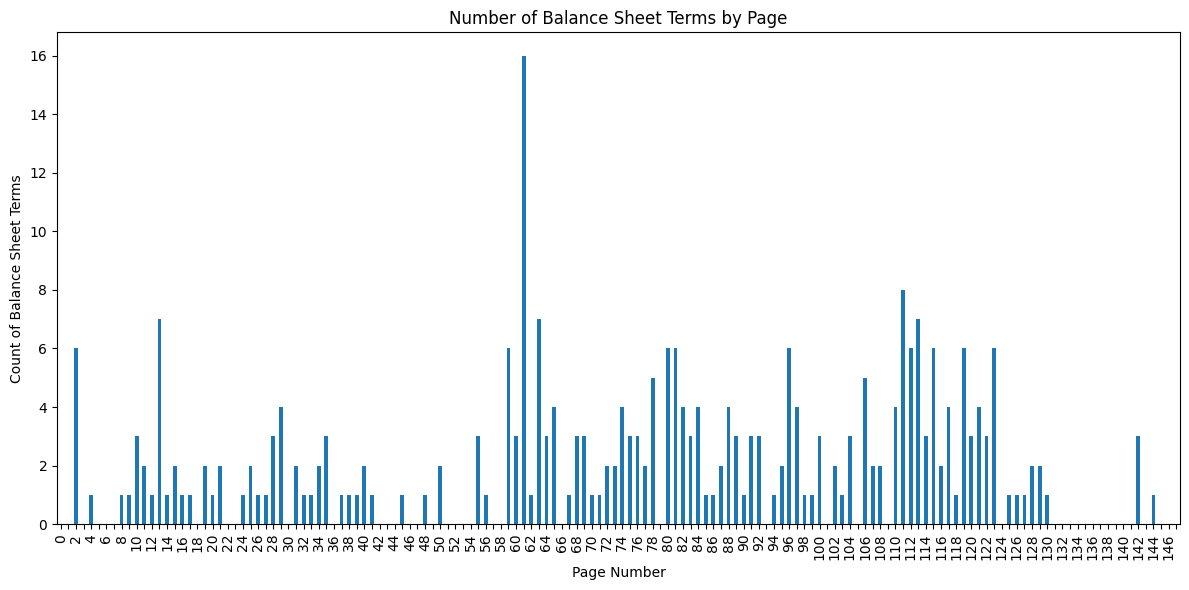

second_max: 8
max_count: 16
std_count: 2.251717899472518
second_max: 8
snr:       7.105685842683989
snr_second:2.0


In [78]:
sha1_i = df_subset_filtered["sha1"].iloc[2]
pdf_name_i = sha1_i + ".pdf"
output_path = f"../data_in/temp/EnterpriseRAG_2025_02_markdown/{sha1_i}/{sha1_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text3 = f.read()

res = count_phrases_by_page(text3, balance_sheet_words3)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")


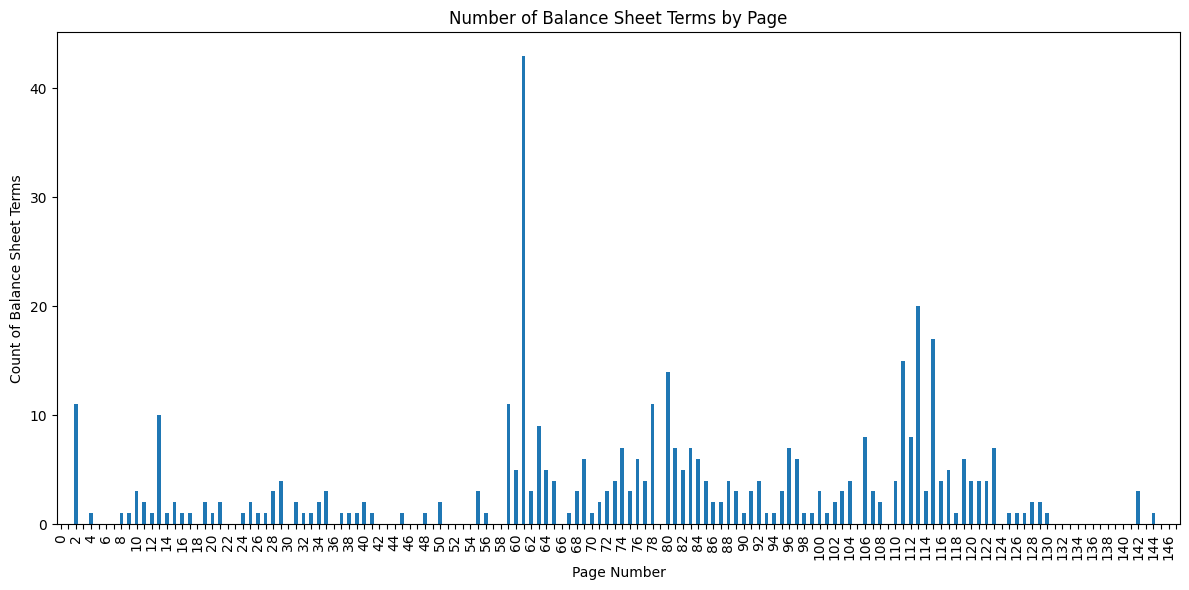

second_max: 20
max_count: 43
std_count: 4.786794668577031
second_max: 20
snr:       8.983046689316758
snr_second:2.15


In [79]:
res = count_phrases_by_page(text3, balance_sheet_words5)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

In [82]:
bs_page = get_page_text(text3, 61)
print(bs_page)



#### **Consolidated Statement of Financial Position**

as at 30 June 2022

|                                                                 | Note     | 2022<br>\$'m  | 2021<br>\$'m    |
|-----------------------------------------------------------------|----------|---------------|-----------------|
|                                                                 |          |               |                 |
| ASSETS                                                          |          |               |                 |
| Current assets                                                  |          |               |                 |
| Cash and cash equivalents                                       | C1(c)    | 738.5         | 811.4           |
| Trade receivables and contract assets<br>Other financial assets | C2<br>G3 | 1,953.0       | 2,121.0<br>62.7 |
| Inventories                                                     | C3       | 28.2<br>208.9 | 254.2           |
| Lease receivables

In [83]:
first_column = extract_first_column_from_table(bs_page)

print("\n".join(first_column))


assets
current assets
cash and cash equivalents
trade receivables and contract assetsother financial assets
inventories
lease receivables
current tax assets
prepayments and other assets
assets held for sale
total current assets
non-current assets
trade receivables and contract assets
equity accounted investments
property, plant and equipment
right-of-use assets
intangible assets
other financial assets
deferred tax assets
prepayments and other assets
total non-current assets
total assets
liabilities
current liabilities
trade payables and contract liabilities
borrowings
lease liabilities
other financial liabilities
employee benefits provision
other provisions
current tax liabilities
liabilities held for sale
total current liabilities
non-current liabilities
trade payables and contract liabilities
borrowings
lease liabilities
other financial liabilities
employee benefits provision
other provisions
deferred tax liabilities
total non-current liabilities
total liabilities
net assets
equity
i

### Text 4

'../data_in/temp/EnterpriseRAG_2025_02_markdown/105688726e097505beef4934896193ac51295037/105688726e097505beef4934896193ac51295037.md'

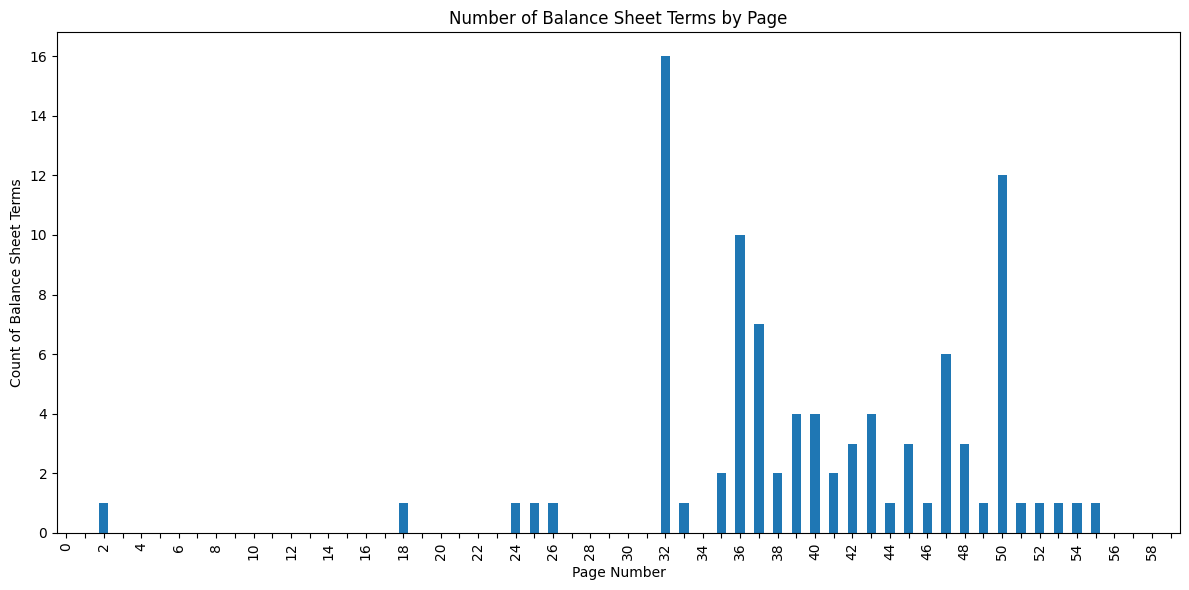

second_max: 12
max_count: 16
std_count: 3.0391048340079343
second_max: 12
snr:       5.264708153847854
snr_second:1.3333333333333333


In [91]:
sha1_i = df_subset_filtered["sha1"].iloc[3]
pdf_name_i = sha1_i + ".pdf"
output_path = f"../data_in/temp/EnterpriseRAG_2025_02_markdown/{sha1_i}/{sha1_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text = f.read()

res = count_phrases_by_page(text, balance_sheet_words5)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

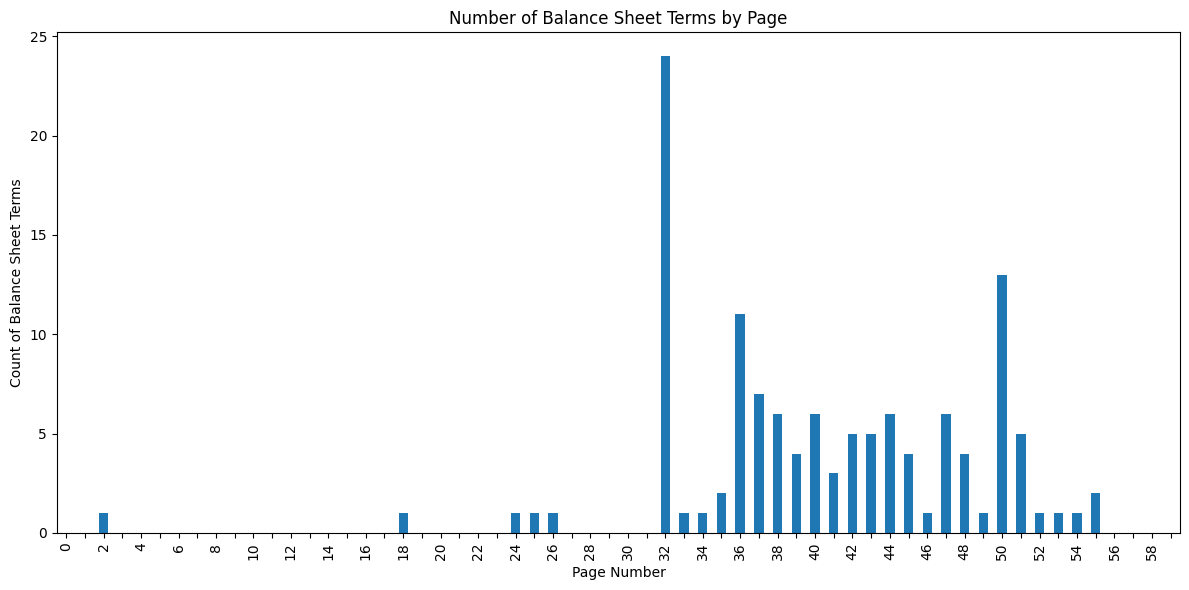

second_max: 13
max_count: 24
std_count: 4.013923507106726
second_max: 13
snr:       5.979187186180194
snr_second:1.8461538461538463


In [92]:
res = count_phrases_by_page(text, balance_sheet_words6)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

In [87]:
bs_page = get_page_text(text, 32)
print(bs_page)



#### **Consolidated Statement of CONSOLIDATED STATEMENT OF FINANCIAL POSITION** AS AT 30 JUNE 2022

**Financial Position** *As at 30 June 2022*

|                                   |      | 2022         | 2021         |
|-----------------------------------|------|--------------|--------------|
|                                   | Note | \$           | \$           |
| Current Assets                    |      |              |              |
| Cash and cash equivalents         |      | 1,510,559    | 1,419,805    |
| Trade and other receivables       | 4    | 92,754       | 107,749      |
| Prepayments                       | 5    | 176,569      | 107,657      |
| Total Current Assets              |      | 1,779,882    | 1,635,211    |
|                                   |      |              |              |
| Non-Current Assets                |      |              |              |
| Motor Vehicles                    | 6    | 71,551       | 94,736       |
| Plant and Equipment       

In [88]:
first_column = extract_first_column_from_table(bs_page)
print("\n".join(first_column))

current assets
cash and cash equivalents
trade and other receivables
prepayments
total current assets
non-current assets
motor vehicles
plant and equipment
exploration and evaluation assets
total non-current assets
total assets
current liabilities
trade and other payables
provisions
total current liabilities
total liabilities
net assets
equity
issued capital
reserves
accumulated losses
total equity


### Text 5

'../data_in/temp/EnterpriseRAG_2025_02_markdown/12bff07b957b1c8f8cad9d917ca18005720cce9b/12bff07b957b1c8f8cad9d917ca18005720cce9b.md'

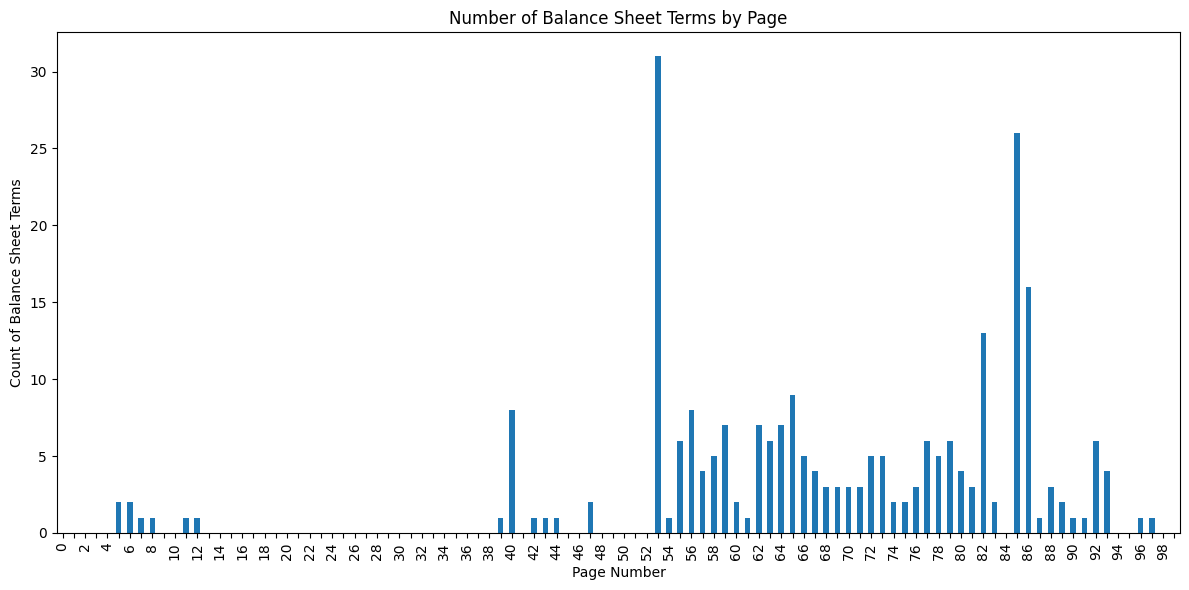

second_max: 26
max_count: 31
std_count: 4.7638686426521515
second_max: 26
snr:       6.507316285434271
snr_second:1.1923076923076923


In [93]:
sha1_i = df_subset_filtered["sha1"].iloc[4]
pdf_name_i = sha1_i + ".pdf"
output_path = f"../data_in/temp/EnterpriseRAG_2025_02_markdown/{sha1_i}/{sha1_i}.md"
output_path
# Read the markdown text from the saved file
with open(output_path, "r", encoding="utf-8") as f:
    text = f.read()

res = count_phrases_by_page(text, balance_sheet_words6)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

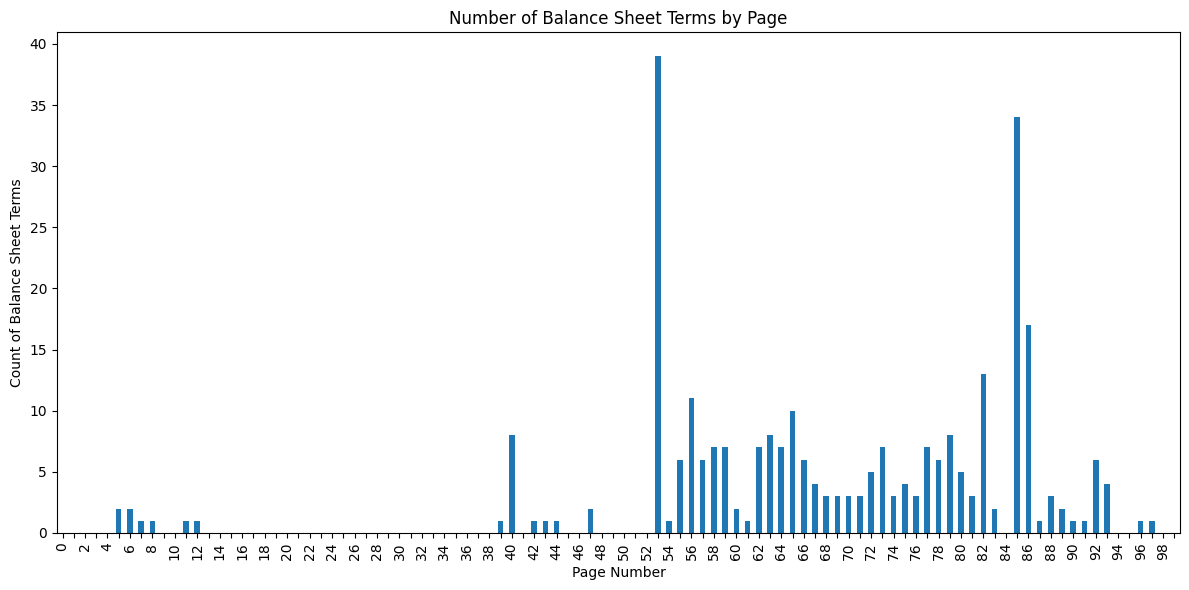

second_max: 34
max_count: 39
std_count: 5.836587836720833
second_max: 34
snr:       6.681986306216776
snr_second:1.1470588235294117


In [104]:
res = count_phrases_by_page(text, balance_sheet_words7)
df = pd.DataFrame.from_dict(res, orient='index')
df2 = (df > 0)*1
sums = df2.sum(axis=1)
# Create a bar plot from the Series
_ = plt.figure(figsize=(12, 6))
ax = sums.plot(kind='bar')
_ = plt.title('Number of Balance Sheet Terms by Page')
_ = plt.xlabel('Page Number')
_ = plt.ylabel('Count of Balance Sheet Terms')

# Show every other label on x axis
for idx, label in enumerate(ax.get_xticklabels()):
    if idx % 2 != 0:
        label.set_visible(False)

_ = plt.tight_layout()
_ = plt.show()

max_count = sums.max()
std_count = sums.std()
snr = max_count/std_count
# Find the second maximum value in the sums Series
if len(sums) > 1:
    # Sort values in descending order and get the second element
    second_max = sums.sort_values(ascending=False).iloc[1]
    print(f"second_max: {second_max}")
else:
    print("Not enough data to find second maximum")
snr_second = max_count/second_max

print(f"max_count: {max_count}")
print(f"std_count: {std_count}")
print(f"second_max: {second_max}")
print(f"snr:       {snr}")
print(f"snr_second:{snr_second}")

In [101]:
bs_page = get_page_text(text, 53)
print(bs_page)



## CONSOLIDATED STATEMENT OF FINANCIAL POSITION AS AT 3 JULY 2022

|                                  |      | 2022      | 2021      |
|----------------------------------|------|-----------|-----------|
|                                  | Note | \$'000    | \$'000    |
| ASSETS                           |      |           |           |
| CURRENT ASSETS                   |      |           |           |
| Cash and cash equivalents        | 6    | 42,763    | 57,831    |
| Other receivables                | 7    | 2,483     | 1,747     |
| Inventories                      | 8    | 116,714   | 110,083   |
| Derivative financial instruments | 9    | 947       | 576       |
| Other current assets             | 10   | 3,334     | 3,982     |
| Income tax receivable            | 5    | 117       | 5,100     |
| TOTAL CURRENT ASSETS             |      | 166,358   | 179,319   |
| NON-CURRENT ASSETS               |      |           |           |
| Plant and equipment              | 11   | 10,

In [102]:
first_column = extract_first_column_from_table(bs_page)
print("\n".join(first_column))

assets
current assets
cash and cash equivalents
other receivables
inventories
derivative financial instruments
other current assets
income tax receivable
total current assets
non-current assets
plant and equipment
right-of-use assets
intangible assets
deferred tax assets
other non-current assets
total non-current assets
total assets
liabilities
current liabilities
trade and other payables
borrowings
provisions
derivative financial instruments
lease liabilities
other current liabilities
deferred consideration
contract liabilities
total current liabilities
non-current liabilities
borrowings
provisions
lease liabilities
other non-current liabilities
financial liabilities
deferred tax liabilities
total non-current liabilities
total liabilities
net assets
equity
issued capital
reserves
accumulated losses
total equity
